<a href="https://colab.research.google.com/github/whgustj00/AI_study/blob/main/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5_%EA%B3%B5%ED%95%99_3%ED%8C%80_%ED%8C%80%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# 필요한 라이브러리를 import 합니다.
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings(action='ignore')

In [33]:
# CSV 파일을 읽어옵니다.
laptop_data = pd.read_csv('/content/laptop_price.csv', encoding_errors='ignore')

In [34]:
laptop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
laptop_data.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [37]:
# 유로를 원화로 변경
laptop_data['Price_euros'] = (laptop_data['Price_euros'] * 1405 / 10000).astype(int)
laptop_data.rename(columns={'Price_euros': 'Price'}, inplace=True)

# Ram의 GB를 제거
laptop_data['Ram'] = laptop_data['Ram'].str.replace('GB', '').astype(int)

# Weight의 kg를 제거
laptop_data['Weight'] = laptop_data['Weight'].str.replace('kg', '').astype(float)

# 불필요한 컬럼 제거
laptop_data = laptop_data.drop(columns=['laptop_ID', 'Product'])

# 범주형 데이터를 정수로 인코딩
label_encoders = {}
for column in ['Company', 'TypeName', 'ScreenResolution', 'Memory','Cpu', 'Gpu', 'OpSys']:
    label_encoders[column] = LabelEncoder()
    laptop_data[column] = label_encoders[column].fit_transform(laptop_data[column])

# 변환된 데이터셋을 확인
laptop_data.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,1,4,13.3,23,65,8,4,58,8,1.37,188
1,1,4,13.3,1,63,8,2,51,8,1.34,126
2,7,3,15.6,8,74,8,16,53,4,1.86,80
3,1,4,15.4,25,85,16,29,9,8,1.83,356
4,1,4,13.3,23,67,8,16,59,8,1.37,253


<Axes: >

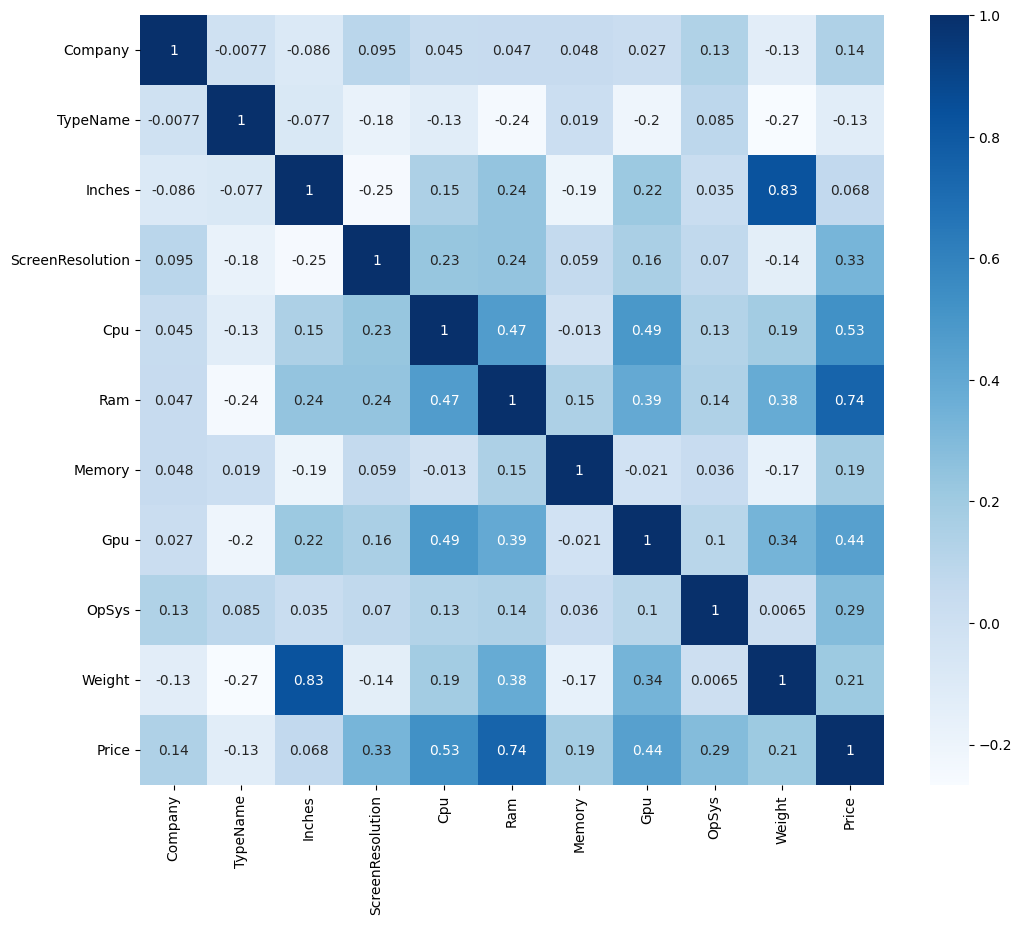

In [38]:
# 상관관계 시각화
plt.figure(figsize = (12,10))

sns.heatmap(laptop_data.corr(), annot =True, cbar=True, cmap='Blues')

In [39]:
laptop_data = laptop_data.drop(columns=['Inches'])

In [40]:
# 1. 결측치 확인
missing_values = laptop_data.isnull().sum()
print(missing_values)

Company             0
TypeName            0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64


In [41]:
# 2. 왜도와 첨도 확인
skew = laptop_data.skew()
kurtosis = laptop_data.kurtosis()
print(f"왜도:\n{skew}\n")
print(f"첨도:\n{kurtosis}\n")

왜도:
Company             0.380199
TypeName           -0.749186
ScreenResolution    1.424279
Cpu                -0.914983
Ram                 2.686806
Memory              0.260799
Gpu                -0.129279
OpSys              -1.562630
Weight              1.144963
Price               1.521653
dtype: float64

첨도:
Company             -0.372718
TypeName            -0.287319
ScreenResolution     2.967103
Cpu                  0.332580
Ram                 15.336512
Memory              -0.688644
Gpu                  0.178074
OpSys                5.812172
Weight               2.455880
Price                4.372160
dtype: float64



In [42]:
# 3. 중복 값 확인
duplicates = laptop_data.duplicated(keep=False).sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 45


In [43]:
# 3-1. 중복 값 조정
laptop_data.drop_duplicates(keep='first', inplace=True)

In [44]:
# 4. 통계치 확인
statistics = laptop_data.describe().round(2)
print(statistics)

       Company  TypeName  ScreenResolution      Cpu      Ram   Memory  \
count  1273.00   1273.00           1273.00  1273.00  1273.00  1273.00   
mean      6.47      2.58              9.33    77.39     8.44    16.28   
std       4.10      1.25              7.88    24.96     5.10     7.94   
min       0.00      0.00              0.00     0.00     2.00     0.00   
25%       4.00      1.00              7.00    68.00     4.00    10.00   
50%       7.00      3.00              8.00    78.00     8.00    16.00   
75%      10.00      3.00             15.00    97.00     8.00    23.00   
max      18.00      5.00             39.00   117.00    64.00    38.00   

           Gpu    OpSys   Weight    Price  
count  1273.00  1273.00  1273.00  1273.00  
mean     54.96     4.81     2.04   159.08  
std      21.64     1.04     0.67    98.47  
min       0.00     0.00     0.69    24.00  
25%      47.00     5.00     1.50    85.00  
50%      53.00     5.00     2.04   138.00  
75%      72.00     5.00     2.31  

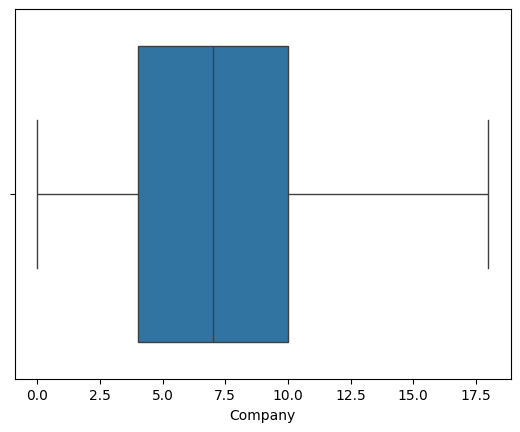

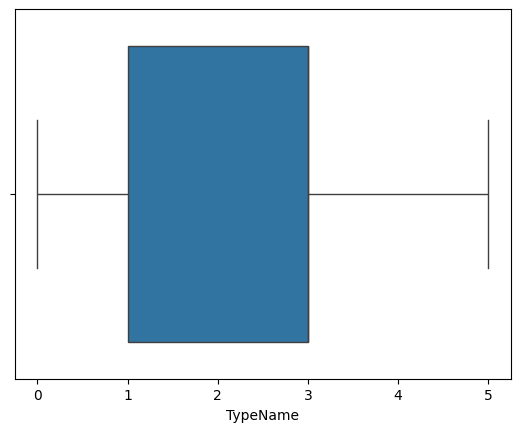

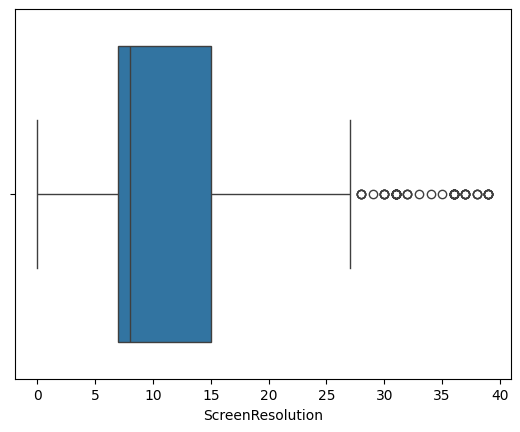

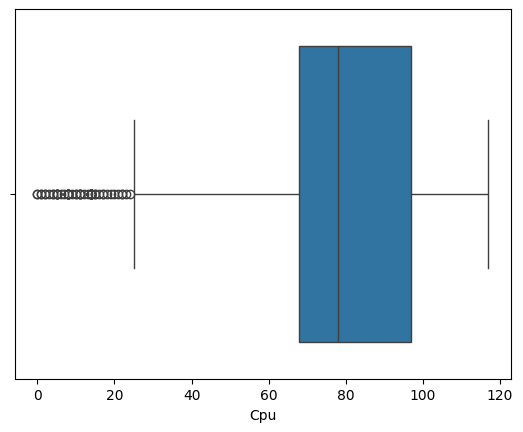

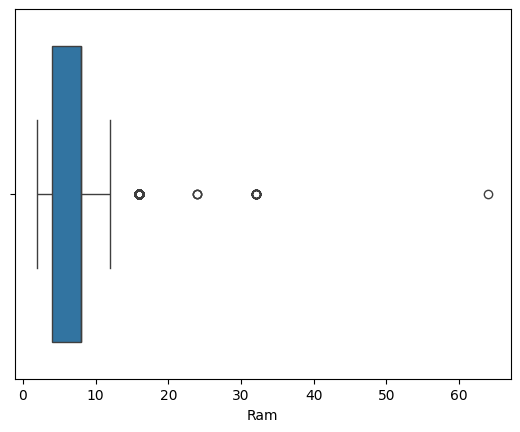

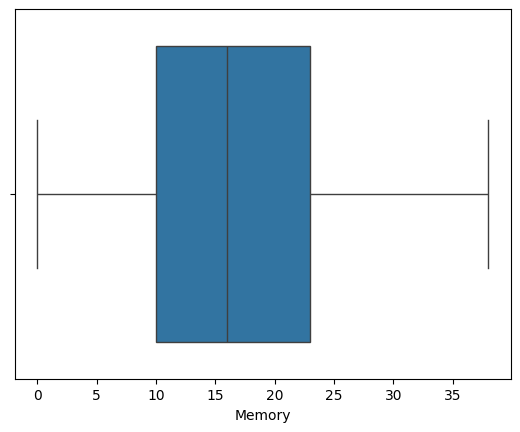

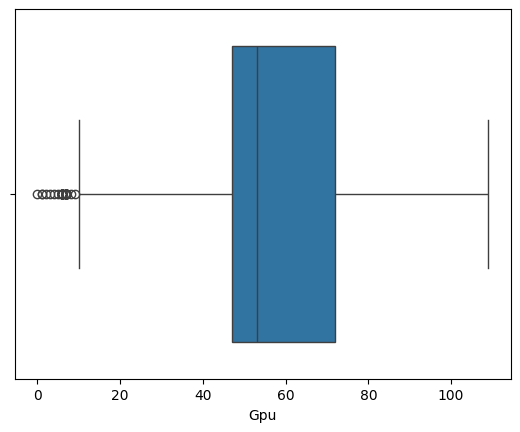

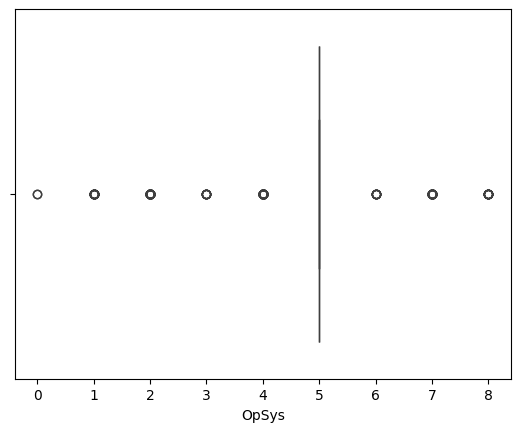

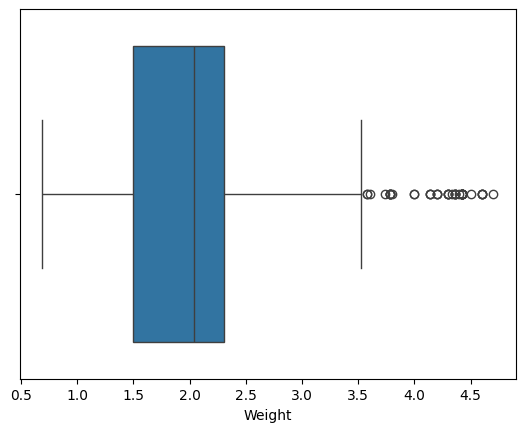

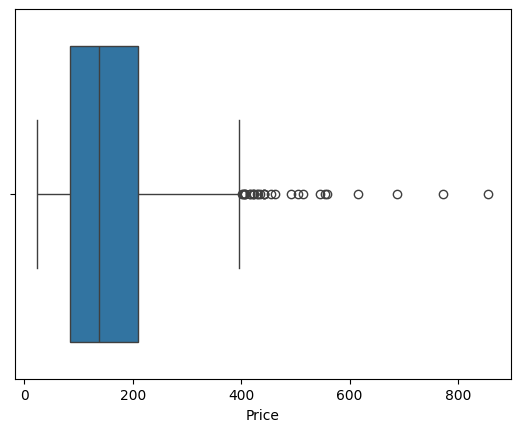

In [45]:
# 5. 이상치 확인
numeric_columns = laptop_data.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_columns:
    sns.boxplot(x=laptop_data[col])
    plt.show()

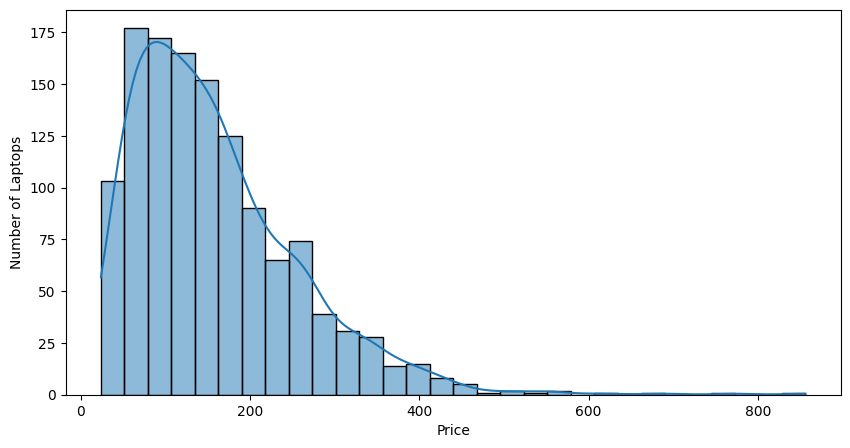

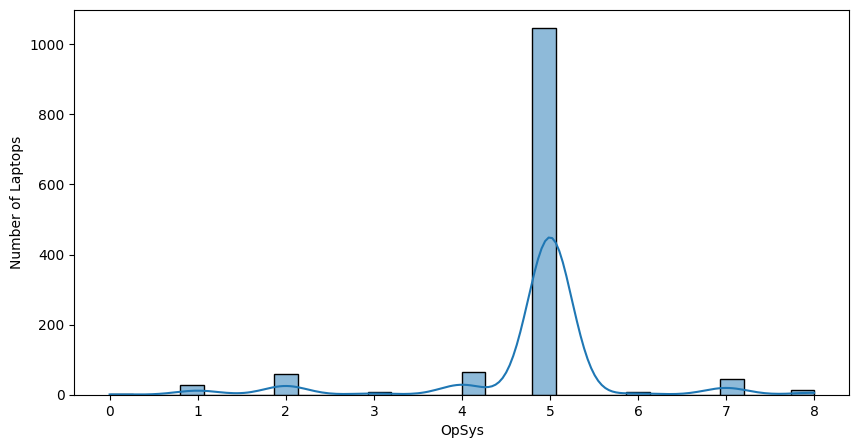

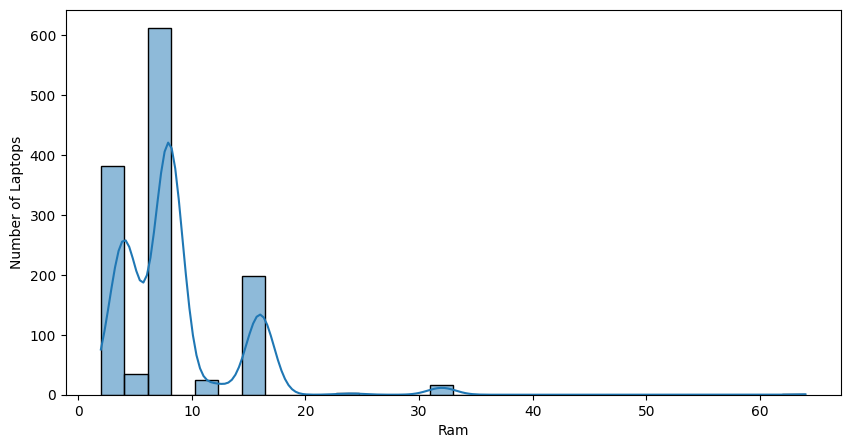

In [46]:
# 시각화
plt.figure(figsize=(10, 5))
sns.histplot(laptop_data['Price'], bins=30, kde=True)
plt.xlabel('Price')
plt.ylabel('Number of Laptops')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(laptop_data['OpSys'], bins=30, kde=True)
plt.xlabel('OpSys')
plt.ylabel('Number of Laptops')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(laptop_data['Ram'], bins=30, kde=True)
plt.xlabel('Ram')
plt.ylabel('Number of Laptops')
plt.show()

In [47]:
# 이상치를 상한값과 하한값으로 치환
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# 이상치를 조정하려는 컬럼명을 정의
numeric_columns = laptop_data.select_dtypes(include=['float64', 'int64']).columns

# 이상치를 상한값, 하한값으로 조정
for column in numeric_columns:
    laptop_data = cap_outliers(laptop_data, column)

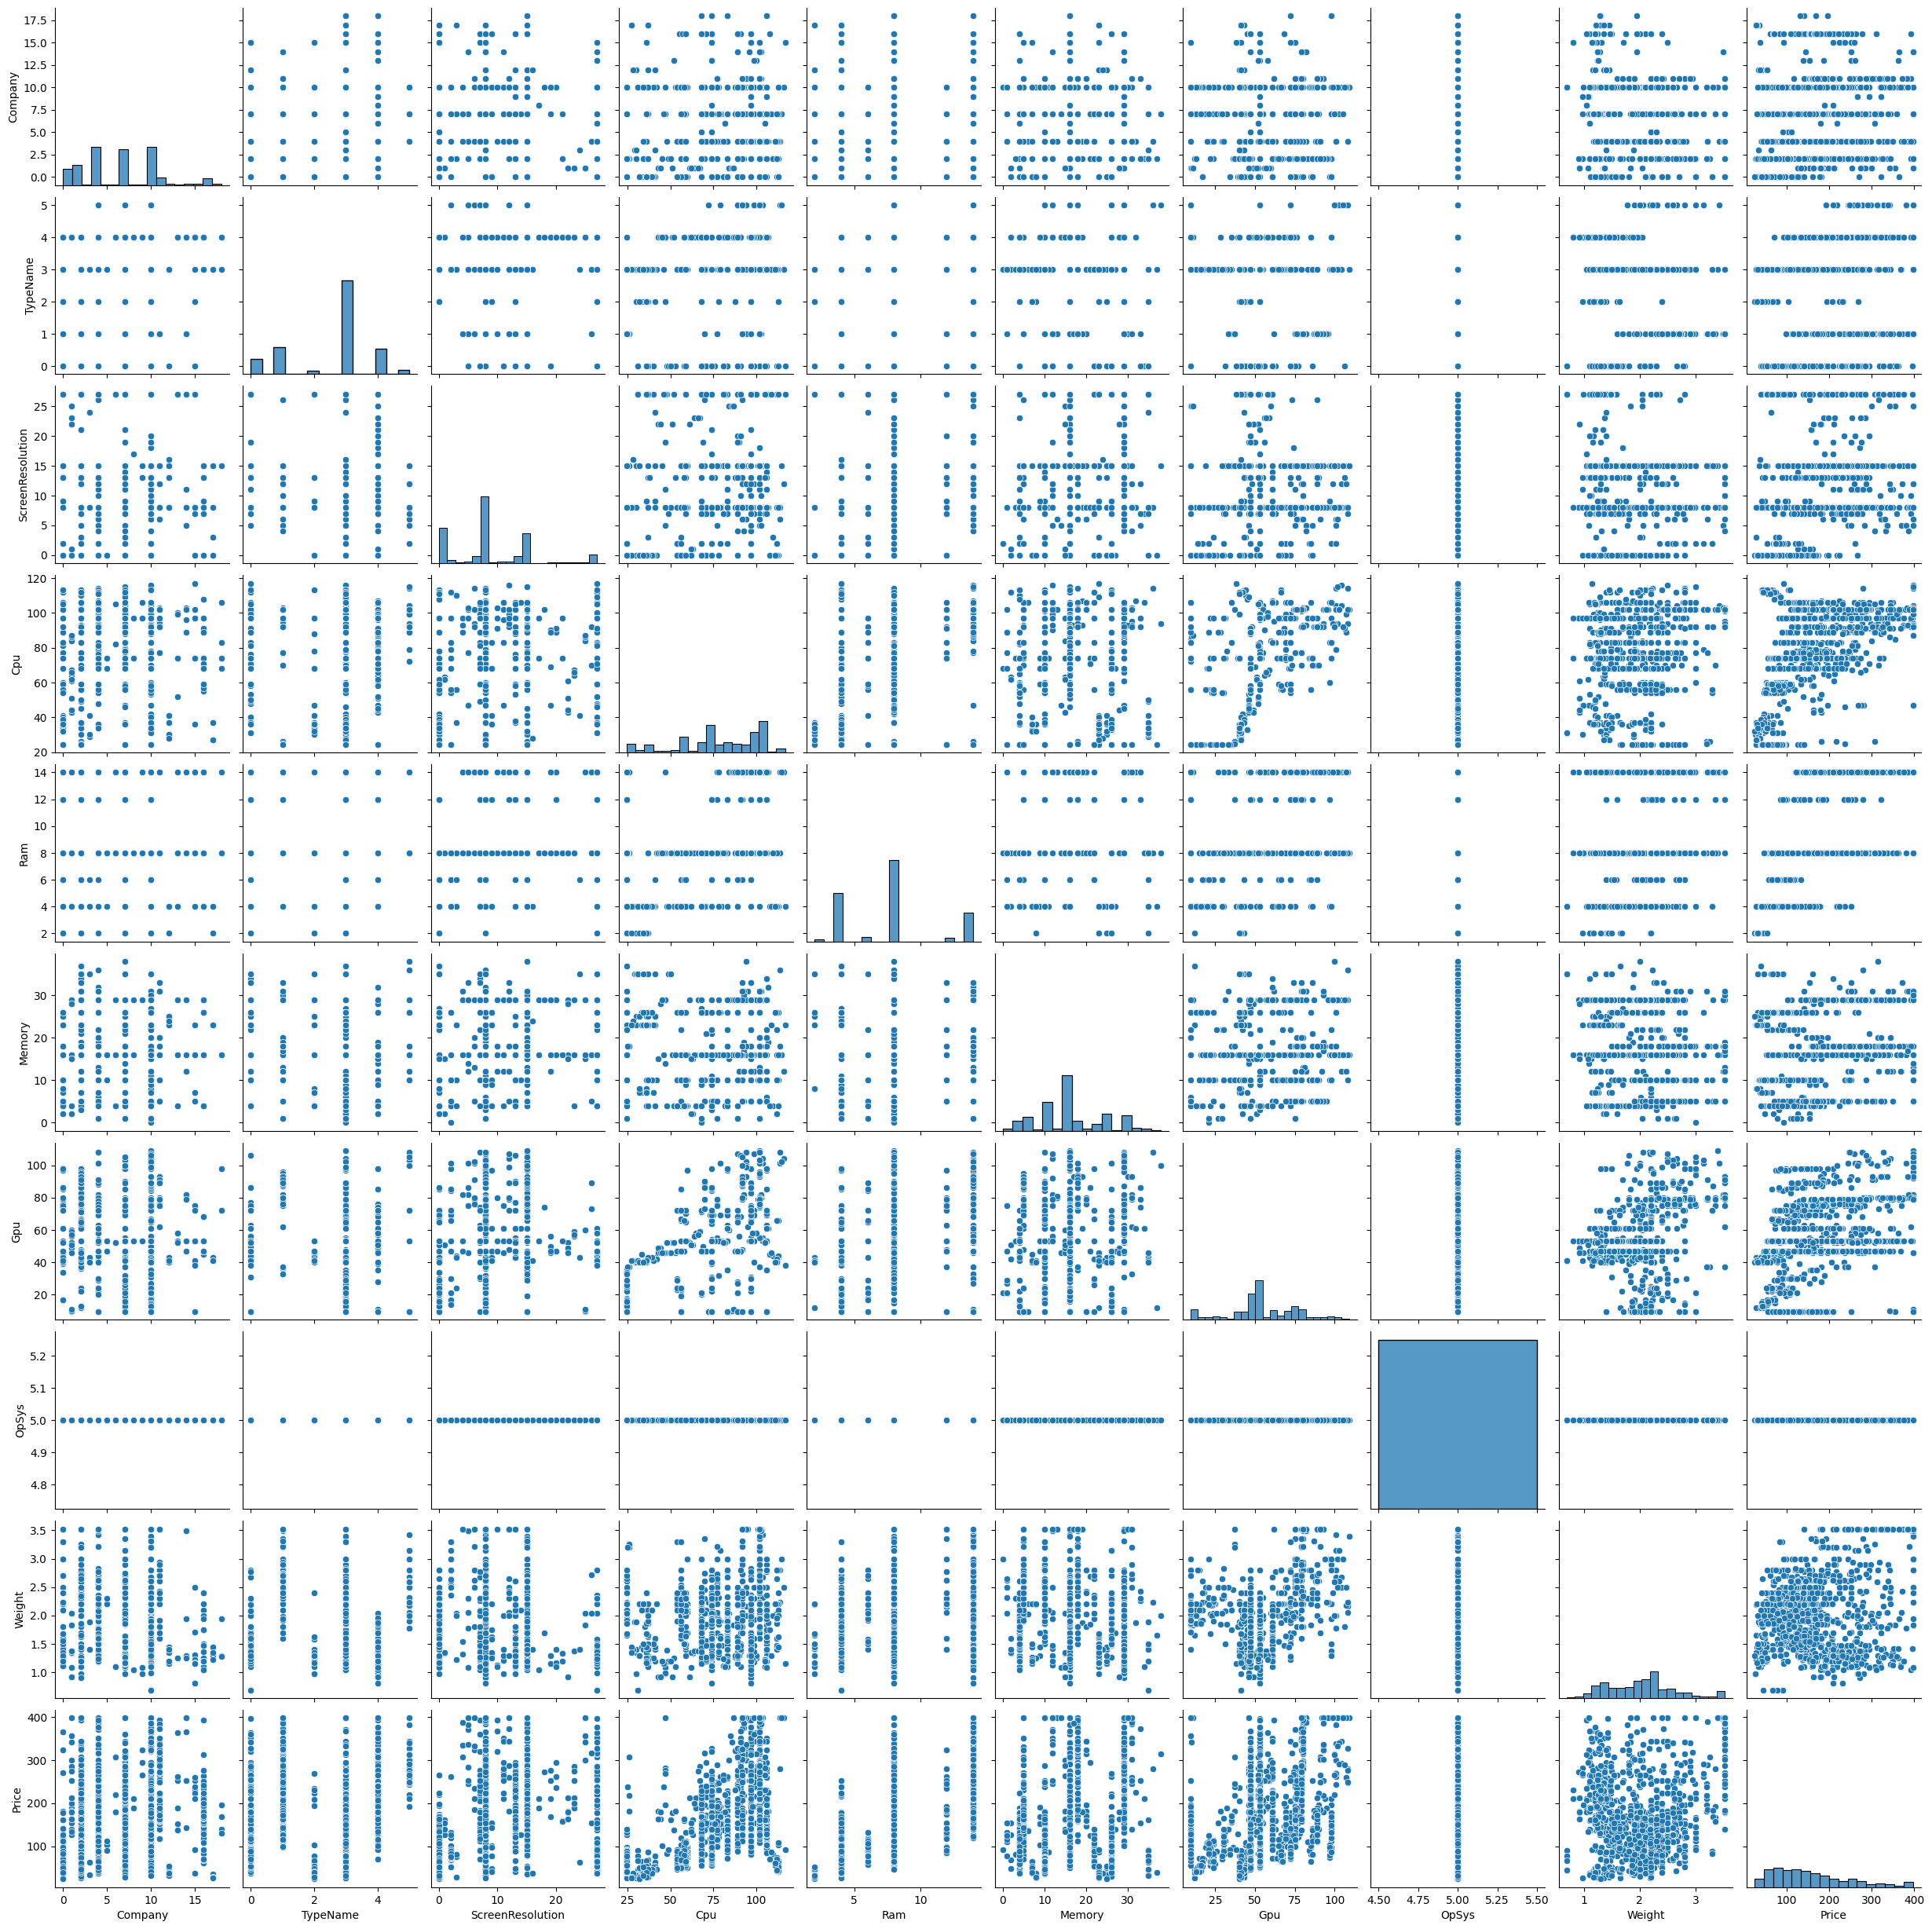

In [48]:
# 6. 산점도
sns.pairplot(laptop_data[numeric_columns])
plt.show()

<Axes: >

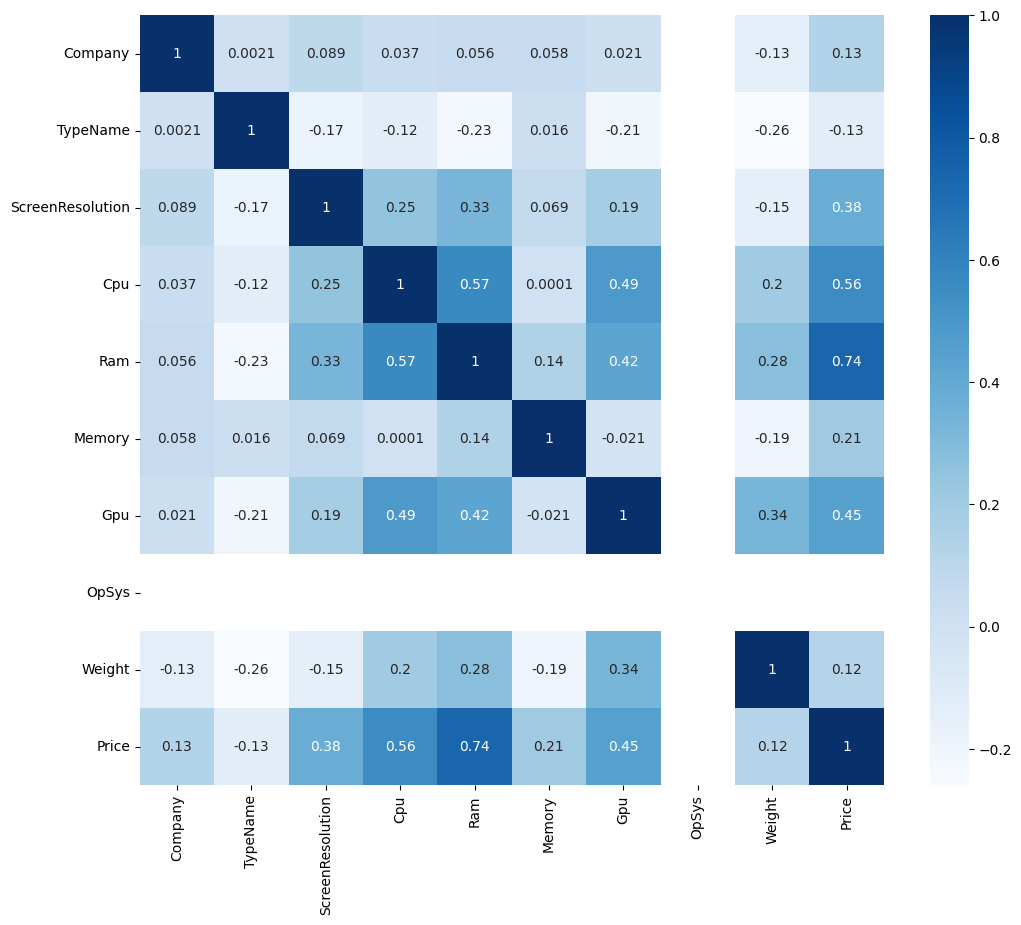

In [49]:
plt.figure(figsize = (12,10))

sns.heatmap(laptop_data.corr(), annot =True, cbar=True, cmap='Blues')

In [50]:
# 7. 다중공선성 확인
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i)
                        for i in range(len(dataframe.columns))]
    return vif_data

In [51]:
# 비수치형 데이터를 수치형으로 변환
numeric_data = laptop_data.select_dtypes(exclude=['object'])
non_numeric_data = laptop_data.select_dtypes(include=['object'])
for column in non_numeric_data.columns:
    non_numeric_data[column] = non_numeric_data[column].astype('category').cat.codes

# 수치형과 비수치형 데이터를 다시 결합합니다.
sub_data = pd.concat([numeric_data, non_numeric_data], axis=1)

# VIF 계산
vif_data = calculate_vif(sub_data.drop(['Price'], axis=1))
print(vif_data)

            feature        VIF
0           Company   1.030125
1          TypeName   1.146414
2  ScreenResolution   1.264874
3               Cpu   1.680220
4               Ram   1.803219
5            Memory   1.095060
6               Gpu   1.478846
7             OpSys  45.105930
8            Weight   1.422391


In [52]:
# 8. 데이터셋 분할

X = laptop_data[['Cpu', 'Ram', 'Gpu', 'ScreenResolution']]
y = laptop_data[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

평균 제곱 오차 (MSE): 2932.6491534632883
평균 절대 오차 (MAE): 42.61881594790127
결정 계수: 0.5981308514535657


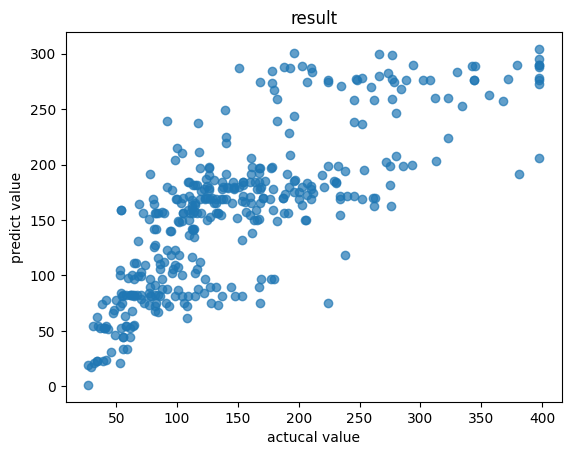

In [53]:
# 9. 다중 회귀분석

# 모델 생성
model = LinearRegression()
model.fit(X_train, y_train)

# 예측값 저장
y_pred = model.predict(X_test)

# 성능 측정 및 출력
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r = r2_score(y_test, y_pred)

print('평균 제곱 오차 (MSE):', mse)
print('평균 절대 오차 (MAE):', mae)
print('결정 계수:', r)

# 결과 시각화
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('actucal value')
plt.ylabel('predict value')
plt.title('result')
plt.show()

평균 제곱 오차 (MSE): 1672.051797281736
평균 절대 오차 (MSE): 29.560114386488173
결정 계수: 0.7708740470009454


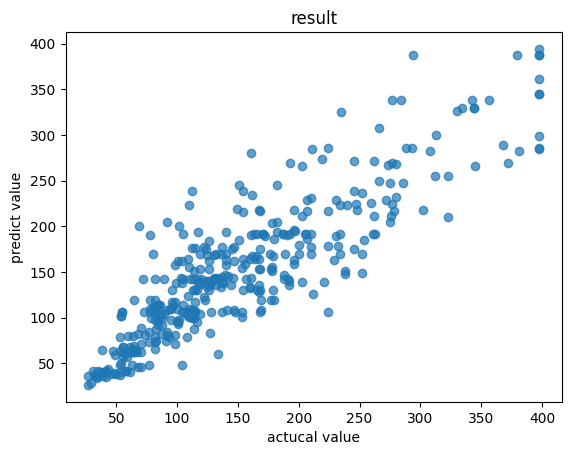

In [54]:
# 10. 랜덤 포레스트

# 랜덤 포레스트 회귀 모델 생성
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 예측값 저장
y_pred = model.predict(X_test)

# 성능 측정 및 출력
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r = r2_score(y_test, y_pred)

print('평균 제곱 오차 (MSE):', mse)
print('평균 절대 오차 (MSE):', mae)
print('결정 계수:', r)

# 결과 시각화
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('actucal value')
plt.ylabel('predict value')
plt.title('result')
plt.show()

In [55]:
# 10-1. 랜덤 포레스트 모델 생성
model = RandomForestRegressor(random_state=42)

# 튜닝할 하이퍼파라미터 그리드 지정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Grid Search를 사용하여 최적의 하이퍼파라미터 조합 검색
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 모델과 하이퍼파라미터 출력
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print('Grid Search로 찾은 최적 모델:', best_model)
print('Grid Search로 찾은 최적 하이퍼파라미터:', best_params)

Grid Search로 찾은 최적 모델: RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)
Grid Search로 찾은 최적 하이퍼파라미터: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


평균 제곱 오차 (MSE): 1655.968927019147
평균 절대 오차 (MAE): 30.004576974346158
결정 계수: 0.773077927874652


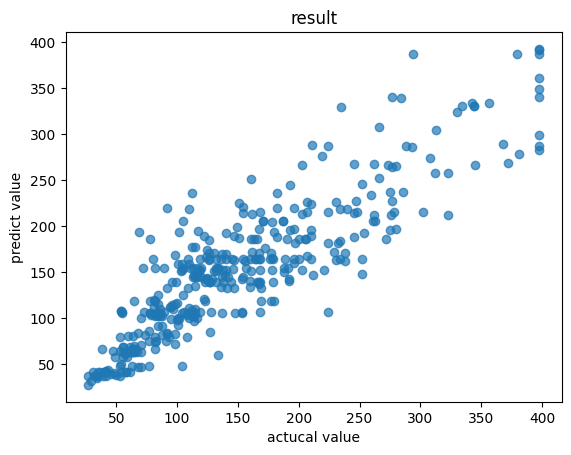

In [56]:
# 10-2. 최적 하이퍼파라미터로 랜덤 포레스트 모델 생성
best_model = RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

# 모델 훈련
best_model.fit(X_train, y_train)

# 예측값 저장
y_pred = best_model.predict(X_test)

# 성능 측정 및 출력
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r = r2_score(y_test, y_pred)

print('평균 제곱 오차 (MSE):', mse)
print('평균 절대 오차 (MAE):', mae)
print('결정 계수:', r)

# 결과 시각화
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('actucal value')
plt.ylabel('predict value')
plt.title('result')
plt.show()

In [57]:
# K-겹 교차 검증을 사용한 성능 평가
mse_scores = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mae_scores = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')

# 출력
print('K-겹 교차 검증 MSE 결과:')
for i, mse in enumerate(mse_scores, start=1):
    print(f'K-겹 교차 검증 {i}의 MSE: {mse}')

print('\nK-겹 교차 검증 MAE 결과:')
for i, mae in enumerate(mae_scores, start=1):
    print(f'K-겹 교차 검증 {i}의 MAE: {mae}')

print('\nK-겹 교차 검증 결정 계수 (R-squared) 결과:')
for i, r2 in enumerate(r2_scores, start=1):
    print(f'K-겹 교차 검증 {i}의 결정 계수 (R-squared): {r2}')

print(f'평균 제곱 오차 (MSE): {mse_scores.mean()}')
print(f'평균 절대 오차 (MAE): {mae_scores.mean()}')
print(f'평균 결정 계수 (R-squared): {r2_scores.mean()}')

K-겹 교차 검증 MSE 결과:
K-겹 교차 검증 1의 MSE: 2079.77541690993
K-겹 교차 검증 2의 MSE: 2346.8910554936183
K-겹 교차 검증 3의 MSE: 2238.481707097744
K-겹 교차 검증 4의 MSE: 2172.934742126478
K-겹 교차 검증 5의 MSE: 2015.790031450385

K-겹 교차 검증 MAE 결과:
K-겹 교차 검증 1의 MAE: 30.84985375090196
K-겹 교차 검증 2의 MAE: 33.48720089670926
K-겹 교차 검증 3의 MAE: 31.466979544133547
K-겹 교차 검증 4의 MAE: 31.516362659240954
K-겹 교차 검증 5의 MAE: 32.872629061934646

K-겹 교차 검증 결정 계수 (R-squared) 결과:
K-겹 교차 검증 1의 결정 계수 (R-squared): 0.7370318919570344
K-겹 교차 검증 2의 결정 계수 (R-squared): 0.709416591925009
K-겹 교차 검증 3의 결정 계수 (R-squared): 0.7465663269231113
K-겹 교차 검증 4의 결정 계수 (R-squared): 0.7769560675780726
K-겹 교차 검증 5의 결정 계수 (R-squared): 0.7538119832787841
평균 제곱 오차 (MSE): 2170.7745906156315
평균 절대 오차 (MAE): 32.03860518258408
평균 결정 계수 (R-squared): 0.7447565723324023


평균 제곱 오차 : 1593.2287811451604
평균 절대 오차 : 30.370532735860614
결정 계수 : 0.7816753862416996


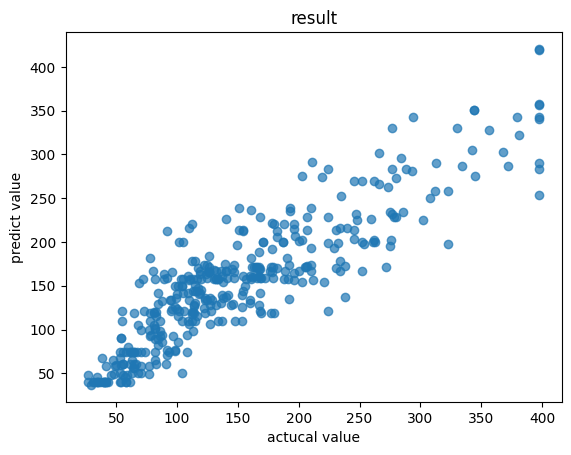

In [58]:
# 그래디언트 부스팅 회귀 모델
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()

# 모델 훈련
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'평균 제곱 오차 : {mse}')
print(f'평균 절대 오차 : {mae}')
print(f'결정 계수 : {r2}')

# 결과 시각화
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('actucal value')
plt.ylabel('predict value')
plt.title('result')
plt.show()